# Visualization of the final Minimum Spanning Tree (MST)
This notebook applies the Sequencer to the simple simulated dataset and visualizes the resulting final Minimum Spanning Tree (MST). The final MST is obtained by populating the intermediate MSTs (of each chunk, scale, and metric) into a proximity matrix, weighted by their elongations. The elongation of the final MST serves as a figure of merit of the resulting sequence. <br>
By visualizing the resulting MST, we can examine the topological properties of our data. For example, the structure of the MST can reveal that the data consists of clusters, a sequence, a sequence which is split into two sequence (fork), etc.

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib scikit-learn
#!pip install umap-learn
#!pip install TheSequencer

In [13]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import umap
import networkx as nx

import sys
sys.path.append("/Users/dalyabaron/Documents/EMD/Sequencer/")
import sequencer

In [6]:
sequencer?

## 1. Simulating a dataset with a clear one-dimensional sequence

In this part of the notebook I will construct a simple dataset with small-scale and large-scale fluctuations. <br>
The dataset will consist of 200 1D objects, each with 400 pixels. This dataset is similar to the dataset shown in the paper and is described in detail in the Jupyter notebook: ```comparison_with_tsne_and_umap.ipynb``` in the examples directory. 

(200, 400)


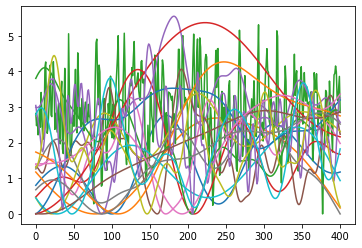

In [7]:
# start by constructing the continuum fluctuations on small and large scales
def squared_exponential(x1, x2, h):
    return numpy.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

numpy.random.seed(1)
x = numpy.linspace(0, 400, 400)
mu = numpy.zeros(len(x))

draws = []
h_list = numpy.random.uniform(1, 100, 200)
for h_val in h_list:
    C = squared_exponential(x, x[:, None], h_val)
    draw_val = numpy.random.multivariate_normal(mu, C, 1).flatten()
    draws.append(draw_val)
    
draws = numpy.array(draws)
print(draws.shape)

# plot 20 examples
for i in range(20):
    plt.plot(x, draws[i] - numpy.min(draws[i]))

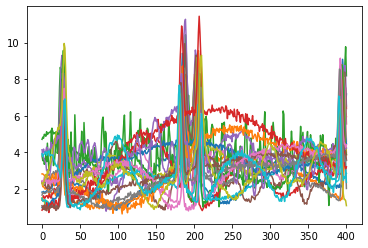

In [8]:
# construct the synthetic dataset by adding narrow pulses that form a clear 1D sequence, and add some iid noise

# narrow pulses properties
mu_list_1 = numpy.linspace(25*2, 50*2, 200) - 25
mu_list_2 =  numpy.linspace(190, 90, 200)
mu_list_3 = numpy.linspace(100*2, 150*2, 200)
mu_list_4 = numpy.linspace(400, 150*2, 200)
sigma_val = 2.

objects_list = []
for i in range(200):
    # define the continuum
    continuum_val = draws[i]
    continuum_pos = continuum_val - numpy.min(continuum_val)
    
    # define iid Gaussian noise that you will add to these objects
    noise = numpy.random.normal(loc=0, scale=0.1 * numpy.std(continuum_pos), size=len(continuum_pos))
    
    # define the narrow pulses
    mu_val_1 = mu_list_1[i]
    mu_val_2 = mu_list_2[i]
    mu_val_3 = mu_list_3[i]
    mu_val_4 = mu_list_4[i]
    narrow_pulses = 5 * numpy.exp(-(mu_val_1 - x)**2/(2*sigma_val**2)) + \
                    5 * numpy.exp(-(mu_val_2 - x)**2/(2*sigma_val**2)) + \
                    5 * numpy.exp(-(mu_val_3 - x)**2/(2*sigma_val**2)) + \
                    5 * numpy.exp(-(mu_val_4 - x)**2/(2*sigma_val**2))
    
    # define the total spectrum
    total_object = 1. + continuum_pos + noise + narrow_pulses
    objects_list.append(total_object)
    
objects_list = numpy.array(objects_list)
grid = numpy.linspace(0, 400, 400)

# plot a sample of 20 objects from the objects list
for i in range(20):
    plt.plot(x, objects_list[i])

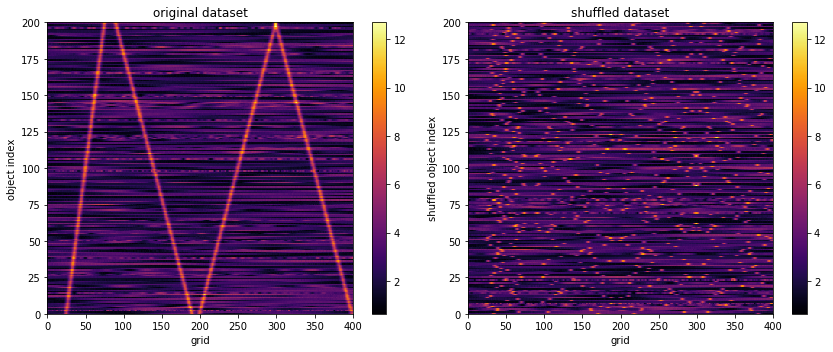

In [9]:
# shuffle the original dataset, and produce a plot showing the original dataset and the shuffled version
indices = numpy.arange(len(objects_list))
numpy.random.shuffle(indices)
objects_list_shuffled = objects_list[indices, :]

plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("original dataset")
plt.pcolormesh(objects_list, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("object index")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("shuffled dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()

plt.tight_layout()

## 2. Apply the Sequencer to the shuffled dataset

In this part of the notebook I will apply the Sequencer to the shuffled dataset, and will print the elongation of the resulting MST. Then, I will extract the final MST and will use ```networkx``` to visualize the tree.

In [10]:
# apply the Sequencer to this data
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, to_average_N_best_estimators=True,
                                               number_of_best_estimators=3)

print("resulting elongation for the Sequencer: ", final_elongation)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.9683899879455566 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 6.033847808837891 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 7.148032188415527 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 12.320979833602905 seconds
calculating the distance matrices for estimator: EMD, scale: 16
finished calculating this distance matrix list, it took: 23.490764617919922 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 2.709861993789673 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it 

/Users/dalyabaron/Documents/EMD/Sequencer/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>
resulting elongation for the Sequencer:  58.5209


In [11]:
# print all the metrics and scales, and examine the intermediate elongations
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 10.29
metric=EMD, scale=2, elongation: 6.39
metric=EMD, scale=4, elongation: 5.43
metric=EMD, scale=8, elongation: 8.48
metric=EMD, scale=16, elongation: 16.7
metric=energy, scale=1, elongation: 11.6
metric=energy, scale=2, elongation: 9.58
metric=energy, scale=4, elongation: 5.43
metric=energy, scale=8, elongation: 10.52
metric=energy, scale=16, elongation: 21.68
metric=KL, scale=1, elongation: 6.05
metric=KL, scale=2, elongation: 9.05
metric=KL, scale=4, elongation: 25.2
metric=KL, scale=8, elongation: 39.14
metric=KL, scale=16, elongation: 54.65
metric=L2, scale=1, elongation: 8.35
metric=L2, scale=2, elongation: 23.02
metric=L2, scale=4, elongation: 31.8
metric=L2, scale=8, elongation: 38.56
metric=L2, scale=16, elongation: 58.52


### Extract the final MST and visualize it:
```networkx``` has several different layouts that one can use to visualize the resulting MST. A useful set of examples is available here: https://networkx.github.io/documentation/stable/auto_examples/index.html. I particularly like the `kamada_kawai_layout`, but the user can change it. 

In [15]:
final_mst = seq.return_final_MST()
type(final_mst)

networkx.classes.graph.Graph

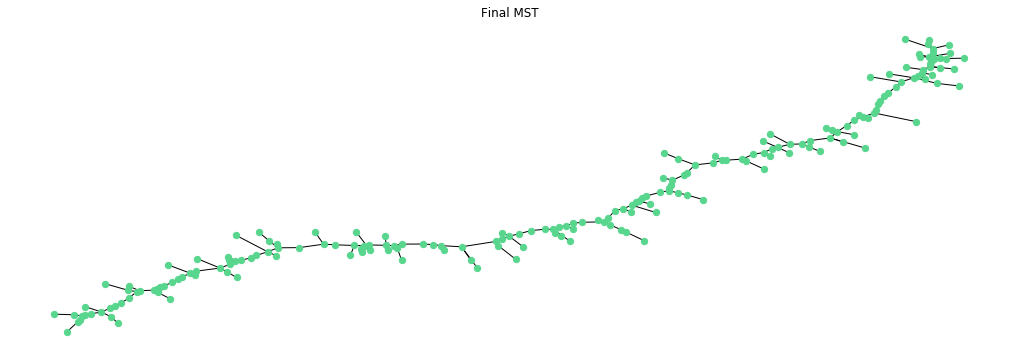

In [22]:
plt.figure(1, figsize=(18, 6))

plt.title("Final MST")
pos = nx.kamada_kawai_layout(final_mst)
nx.draw(final_mst, pos, node_color="#58D68D", node_size=40)